Solution to a problem posted at

https://www.reddit.com/r/statistics/comments/4csjee/finding_pab_given_two_sets_of_data/

So, I have two sets of data where the elements correspond to each other:

    {A} = {122.8, 115.5, 102.5, 84.7, 154.2, 83.7, 122.1, 117.6, 98.1, 111.2, 80.3, 110.0, 117.6, 100.3, 107.8, 60.2}
    {B} = {82.6, 99.1, 74.6, 51.9, 62.3, 67.2, 82.4, 97.2, 68.9, 77.9, 81.5, 87.4, 92.4, 80.8, 74.7, 42.1}

I'm trying to find out the probability that (91.9 <= A <= 158.3) and (56.4 <= B <= 100).
I know that P(91.9 <= A <= 158.3) = 0.727098 and that P(56.4 <= B <= 100) = 0.840273, given that A is a normal distribution with mean 105.5 and standard deviation 21.7 and that B is a normal distribution with mean 76.4 and standard deviation 15.4. However, since they are dependent events, P(BA)=P(A)P(B|A)=P(B)P(A|B). Is there any way that I can find out P(A|B) and P(B|A) given the data that I have?


Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [28]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import scipy

from itertools import product

import thinkbayes2
import thinkplot

%matplotlib inline

Put the data into NumPy arrays

In [2]:
a = np.array([122.8, 115.5, 102.5, 84.7, 154.2, 83.7, 122.1, 
              117.6, 98.1, 111.2, 80.3, 110.0, 117.6, 100.3, 107.8, 60.2])
b = np.array([82.6, 99.1, 74.6, 51.9, 62.3, 67.2, 82.4, 97.2, 
              68.9, 77.9, 81.5, 87.4, 92.4, 80.8, 74.7, 42.1])
n = len(a)
n

16

Take a look at a scatter plot.

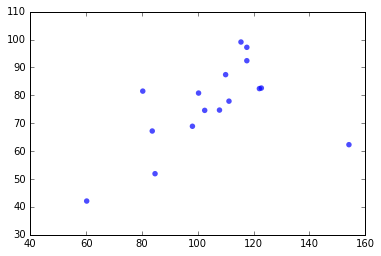

In [3]:
thinkplot.Scatter(a, b, alpha=0.7)

It looks like modeling this data with a bi-variate normal distribution is a reasonable modeling choice.

Let's make an array out of it:

In [4]:
X = np.array([a, b])
X

array([[ 122.8,  115.5,  102.5,   84.7,  154.2,   83.7,  122.1,  117.6,
          98.1,  111.2,   80.3,  110. ,  117.6,  100.3,  107.8,   60.2],
       [  82.6,   99.1,   74.6,   51.9,   62.3,   67.2,   82.4,   97.2,
          68.9,   77.9,   81.5,   87.4,   92.4,   80.8,   74.7,   42.1]])

And compute the sample mean

In [5]:
xbar = X.mean(axis=1)
xbar

array([ 105.5375,   76.4375])

Sample standard deviation

In [6]:
std = X.std(axis=1)
std

array([ 21.04040384,  14.93640163])

Covariance matrix

In [7]:
S = np.cov(X)
S

array([[ 472.21183333,  161.33583333],
       [ 161.33583333,  237.96916667]])

And correlation coefficient

In [8]:
corrcoef = np.corrcoef(a, b)
corrcoef

array([[ 1.       ,  0.4812847],
       [ 0.4812847,  1.       ]])

There are 5 parameters we would like to estimate: $\mu_A$, $\mu_B$, $\sigma_A$, $\sigma_B$, $\rho$.

The following function makes an array of possible values for each parameter.

In [9]:
def make_array(center, stderr, m=11, factor=3):
    return np.linspace(center-factor*stderr, center+factor*stderr, m)

For each parameter, the prior distribution is uniform on a range centered on the estimated value, plus or minus a few standard errors.

Not all combinations of parameters will turn out to be valid, but that's ok.

In [10]:
mu0 = xbar[0]
mu1 = xbar[1]
sig0 = std[0]
sig1 = std[1]
rho = corrcoef[0][1]

mu0_array = make_array(mu0, sig0 / np.sqrt(n))
mu1_array = make_array(mu1, sig1 / np.sqrt(n))
sig0_array = make_array(sig0, sig0 / np.sqrt(2 * (n-1)))
sig1_array = make_array(sig1, sig1 / np.sqrt(2 * (n-1)))
rho_array = make_array(rho, 0.15)

print(min(mu0_array), max(mu0_array))
print(min(mu1_array), max(mu1_array))
print(min(sig0_array), max(sig0_array))
print(min(sig1_array), max(sig1_array))
print(min(rho_array), max(rho_array))

89.75719712 121.31780288
65.2351987751 87.6398012249
9.51610003781 32.5647076422
6.75539753077 23.1174057358
0.0312847033596 0.93128470336


Given the five parameters, we can assemble them into two arrays, mean and cov.

In [15]:
def mean_cov(mu0, mu1, sig0, sig1, rho):
    mean = np.array([mu0, mu1])
    cross = rho * sig0 * sig1
    cov = np.array([[sig0**2, cross], [cross, sig1**2]])
    return mean, cov

Here's the suite that represents each hypothetical set of parameters.  Initially they are all equally likely.

`Likelihood` computes the probability of the data given a hypothetical set of parameters.  If we know the mean is $\mu$ and the covariance matrix is $\Sigma$, the sampling distribution of the mean, $\bar{x}$ is multivariable normal with parameters $\mu$ and $\Sigma/n$.

And the sampling distribution $(n-1) S$ is Wishart with parameters n-1 and $\Sigma$. 

In [16]:
class MultiNorm(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def Likelihood(self, data, hypo):
        mean, cov = mean_cov(*hypo)
        xbar, S, n = data

        try:
            pdf_X = scipy.stats.multivariate_normal(mean, cov/n)
            pdf_S = scipy.stats.wishart(df=n-1, scale=cov)
        except:
            # some combinations of parameters yield covariance matrices that
            # are not positive definite, which means they can't have come
            # from data, so the P(data|hypo) is 0
            return 0
        
        like = pdf_X.pdf(xbar) * pdf_S.pdf((n-1) * S)
        return like

Now we can make a prior distribution using the Cartesian product of the parameter arrays.

In [17]:
suite = MultiNorm(product(mu0_array, mu1_array, sig0_array, sig1_array, rho_array))

And update it using the data (the result is the total probability of the data).

In [18]:
suite.Update((xbar, S, n))

1.6385250666091511e-15

Using the posterior distribution, we can compute the posterior marginal distributions of the parameters, starting with $\mu_a$ and $\mu_b$:

{'xscale': 'linear', 'yscale': 'linear'}

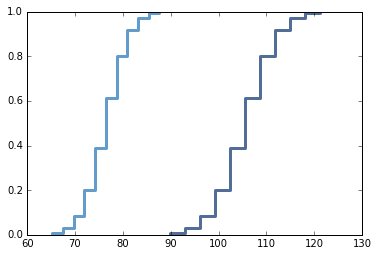

In [19]:
thinkplot.Cdf(suite.Marginal(0).MakeCdf())
thinkplot.Cdf(suite.Marginal(1).MakeCdf())

And here are the posterior marginal distributions for $\sigma_a$ and $\sigma_b$

{'xscale': 'linear', 'yscale': 'linear'}

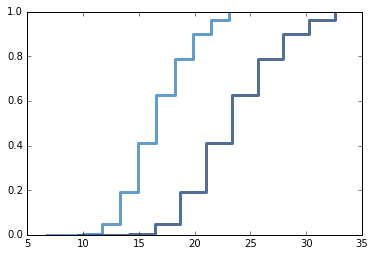

In [20]:
thinkplot.Cdf(suite.Marginal(2).MakeCdf())
thinkplot.Cdf(suite.Marginal(3).MakeCdf())

Finally, the posterior marginal distribution for the correlation coefficient, $\rho$

{'xscale': 'linear', 'yscale': 'linear'}

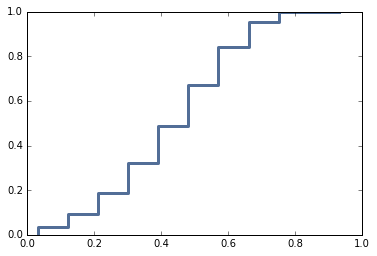

In [21]:
thinkplot.Cdf(suite.Marginal(4).MakeCdf())

Now we can draw a sample of parameters from the posterior distribution, and for each one compute the hypothetical $\mu$ and $\Sigma$ 

In [22]:
stats = [mean_cov(*params) for params in suite.MakeCdf().Sample(1000)]
stats[0]

(array([ 102.38143942,   71.95657951]), array([[ 442.69859375,  258.20539056],
        [ 258.20539056,  461.44216461]]))

The following function takes hypothetical values for $\mu$ and $\Sigma$ and generates a sample of $n$ pairs:

In [25]:
def generate(mean, cov, n):
    return np.random.multivariate_normal(mean, cov, n).transpose()

# run an example using sample stats
generate(xbar, S, n)

array([[  82.98381746,   88.9777055 ,  108.47673082,  134.38046392,
         108.51468145,   93.51235084,   78.19151379,   83.8155497 ,
         102.55007852,  121.95975124,  106.83566883,  105.12494893,
         126.59338608,  106.71660929,   87.57845087,   94.18635493],
       [  48.72881747,   80.16479177,  104.98699043,   68.39942304,
          63.37016238,   85.69653821,   53.06285045,   58.71954304,
          55.1271764 ,   81.93151202,   84.35530579,   76.76608986,
          92.08553397,   68.67550574,   75.41384912,   72.78475991]])

The following function takes a sample of $a$ and $b$ and computes the conditional probabilites P(A|B) and P(B|A)

In [30]:
def conditional_probs(sample):
    df = pd.DataFrame(sample.transpose(), columns=['a', 'b'])
    pA = df[(91.9 <= df.a) & (df.a <= 158.3)]
    pB = df[(56.4 <= df.b) & (df.b <= 100)]
    pBoth = pA.index.intersection(pB.index)
    pAgivenB = len(pBoth) / len(pB)
    pBgivenA = len(pBoth) / len(pA)
    return pAgivenB, pBgivenA

# for testing, compute the conditional probs with the actual data
conditional_probs(X)

(0.8571428571428571, 1.0)

Now we can loop through the sample of parameters (in $\mu$-$\Sigma$ form) and compute the conditional probabilities for each:

In [31]:
pmf = thinkbayes2.Joint()

for mean, cov in stats:
    sample = generate(mean, cov, 1000)
    probs = conditional_probs(sample)
    pmf[probs] += 1

pmf.Normalize()

1000

And then pull out the posterior predictive marginal distribution of P(A|B), with the posterior predictive mean

0.726139858751924

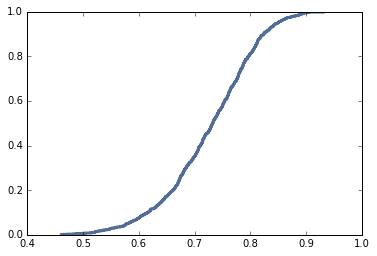

In [32]:
thinkplot.Cdf(pmf.Marginal(0).MakeCdf())
pmf.Marginal(0).Mean()

And then pull out the posterior predictive marginal distribution of P(B|A), with the posterior predictive mean

0.8247268244686035

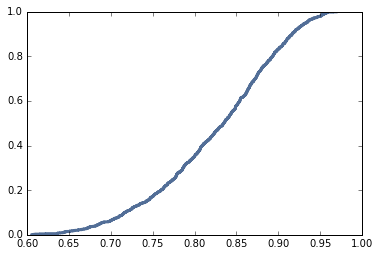

In [33]:
thinkplot.Cdf(pmf.Marginal(1).MakeCdf())
pmf.Marginal(1).Mean()

You can ignore everything below here, which is some of my development code and various checks.

In [ ]:
def std_rho(cov):
    sig1 = np.sqrt(cov[0][0])
    sig2 = np.sqrt(cov[1][1])
    rho = cov[0][1] / sig1 / sig2
    return sig1, sig2, rho

std_rho(cov)

In [ ]:
def estimate(X):
    return X.mean(axis=1), np.cov(X)

In [ ]:
estimate(generate(mean, cov, n))

In [ ]:
def z_prime(r):
    return 0.5 * np.log((1+r) / (1-r))

def sampling_distributions(stats, cov, n):
    sig1, sig2, _ = std_rho(cov)
    
    array = np.zeros((len(stats), 8))
    for i, (xbar, S) in enumerate(stats):
        array[i, 0:2] = xbar
        s1, s2, r = std_rho(S)
        array[i, 2] = s1
        array[i, 3] = s2
        array[i, 4] = r
        array[i, 5] = (n-1) * S[0, 0] / cov[0, 0]
        array[i, 6] = (n-1) * S[1, 1] / cov[1, 1]
        array[i, 7] = z_prime(r)
    return array

dists = sampling_distributions(stats, cov, n)

In [ ]:
cdf0 = thinkbayes2.Cdf(dists[:, 0])
cdf1 = thinkbayes2.Cdf(dists[:, 1])
thinkplot.Cdfs([cdf0, cdf1])

In [ ]:
cdf2 = thinkbayes2.Cdf(dists[:, 2])
cdf3 = thinkbayes2.Cdf(dists[:, 3])
thinkplot.Cdfs([cdf2, cdf3])

In [ ]:
cdf4 = thinkbayes2.Cdf(dists[:, 4])
thinkplot.Cdfs([cdf4])

In [ ]:
cdf5 = thinkbayes2.Cdf(dists[:, 5])
cdf6 = thinkbayes2.Cdf(dists[:, 6])
thinkplot.Cdfs([cdf5, cdf6])

In [ ]:
cdf7 = thinkbayes2.Cdf(dists[:, 7])
thinkplot.Cdfs([cdf7])

In [ ]:
def sampling_dist_mean(i, mean, cov, cdf):
    sampling_dist = scipy.stats.norm(loc=mean[i], scale=np.sqrt(cov[i, i]/n))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_mean(0, mean, cov, cdf0)

In [ ]:
sampling_dist_mean(1, mean, cov, cdf1)

In [ ]:
def sampling_dist_std(i, mean, cov, cdf):
    sampling_dist = scipy.stats.chi2(df=n)
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_std(5, mean, cov, cdf5)

In [ ]:
sampling_dist_std(6, mean, cov, cdf6)

In [ ]:
def sampling_dist_r(i, mean, cov, cdf):
    _, _, rho = std_rho(cov)
    sampling_dist = scipy.stats.norm(loc=z_prime(rho), scale=1/np.sqrt(n-3))
    xs = cdf.xs
    ys = sampling_dist.cdf(xs)
    thinkplot.plot(xs, ys)
    thinkplot.Cdf(cdf)
    
sampling_dist_r(7, mean, cov, cdf7)

In [ ]:
pdf_X = scipy.stats.multivariate_normal(mean, cov/n)

In [ ]:
pdf_X.pdf(mean) - pdf_X.pdf(mean-0.1) 

In [ ]:
def make_multi_norm_marginal(index, mean, cov, n):
    
    sigmas = std_rho(cov)
    width = 6 * sigmas[index] / np.sqrt(n)
    xs = np.linspace(mean[index]-width/2, mean[index]+width/2, 101)
    array = np.tile(mean, (len(xs), 1))
    array[:, index] = xs

    pdf_X = scipy.stats.multivariate_normal(mean, cov/n)
    ys = pdf_X.pdf(array)
    
    pmf = thinkbayes2.Pmf(dict(zip(xs, ys)))
    pmf.Normalize()
    return pmf

pmf = make_multi_norm_marginal(0, mean, cov, n)
thinkplot.Pdf(pmf)

In [ ]:
pmf = make_multi_norm_marginal(1, mean, cov, n)
thinkplot.Pdf(pmf)

In [ ]:
def generate_statistics(mean, cov, n, iters):
    return [estimate(generate(mean, cov, n)) for _ in range(iters)]

stats = generate_statistics(mean, cov, n, 1000)

In [ ]:
s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, (xbar, S) in enumerate(stats):
    sigmas = std_rho(S)
    s0[i] = sigmas[0]
    s1[i] = sigmas[1]

thinkplot.Scatter(s0, s1)

In [ ]:
s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, (xbar, S) in enumerate(stats):
    s0[i] = (n-1) * S[0][0]
    s1[i] = (n-1) * S[1][1]

thinkplot.Scatter(s0, s1)

In [ ]:
pdf_S = scipy.stats.wishart(df=n-1, scale=cov)
stats = pdf_S.rvs(1000)

s0 = np.zeros(len(stats))
s1 = np.zeros(len(stats))

for i, S in enumerate(stats):
    s0[i] = S[0][0]
    s1[i] = S[1][1]

thinkplot.Scatter(s0, s1)

In [ ]:
sigmas = std_rho(cov)
width = 6 * sigmas[0] / np.sqrt(2 * (n-1))
X = np.linspace(sigmas[0]-width/2, sigmas[0]+width/2, 101)

width = 6 * sigmas[1] / np.sqrt(2 * (n-1))
Y = np.linspace(sigmas[1]-width/2, sigmas[1]+width/2, 101)
Z = np.zeros((len(X), len(Y)))

pdf_S = scipy.stats.wishart(df=n-1, scale=cov)

for i, x in enumerate(X):
    for j, y in enumerate(Y):
        S = cov.copy()
        S[0, 0] = x**2
        S[1, 1] = y**2
        try:
            density = pdf_S.pdf((n-1) * S)
            Z[i, j] = density
        except:
            Z[i, j] = np.nan

In [ ]:
thinkplot.Scatter(s0, s1)
plt.contour(X, Y, Z)

In [ ]:
pmf_0 = thinkbayes2.Pmf()

for i, (xbar, S) in enumerate(stats):
    sig1, sig2, rho = std_rho(S)
    density = pdf_S.pdf((n-1) * S)
    pmf_0[sig1] += 1

In [ ]:
thinkplot.Cdf(pmf_0.MakeCdf())


In [ ]:
pdf_S = scipy.stats.wishart(df=n-1, scale=cov)

In [ ]:
pdf_S.pdf(cov)